这次的代码，非监督任务，都是用deepseek生成的。

我发现为什么sop的loss都是nan了。因为sop输入数据是用“.”号分开的，但是这次的数据都已经tokenize好了，没有点号。。。

所以我们强行把一句话拆成两句，就中分。

In [1]:
import sys
from kaitoupao_wsl import *
# from kaitoupao import *

storage dir: /mnt/d/forCoding_data/Tianchi_NLPNewsClassification
code dir: /mnt/d/forCoding_code/Tianchi_NLPNewsClassification 

26 16 23
先天八卦数: 1乾, 2兑, 3离, 4震, 5巽, 6坎, 7艮, 8坤
本卦上：2 本卦下：8 变爻：5


,泽地萃,风山渐,雷地豫
上卦,☱兑金,☴巽木,☳震木
下卦,☷坤土,☶艮土,☷坤土


02 27 9 申时
先天八卦数: 1乾, 2兑, 3离, 4震, 5巽, 6坎, 7艮, 8坤
本卦上：2 本卦下：3 变爻：3


,泽火革,天风姤,泽雷随
上卦,☱兑金,☰乾金,☱兑金
下卦,☲离火,☴巽木,☳震木


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import f1_score

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
device = torch.device("cuda")
# device = torch.device("mps")

In [5]:
scheme_type = "20250326_1" 

# 加载训练集和测试集，将全量字符列表给它弄出来

In [6]:
code_mode = "real_run"

assert code_mode in ("concept_verif", "real_run"), "invalid code mode..."
if code_mode == "concept_verif":
    data_train = pd.read_csv(create_originalData_path("train_set.csv"), sep="\t", nrows=1000)#.sample(1000) , nrows=1000
    data_test = pd.read_csv(create_originalData_path("test_a.csv"), sep="\t", nrows=1000)#.sample(1000)
else:
    data_train = pd.read_csv(create_originalData_path("train_set.csv"), sep="\t")#.sample(1000) , nrows=1000
    data_test = pd.read_csv(create_originalData_path("test_a.csv"), sep="\t")#.sample(1000)

In [7]:
data_train.shape, data_test.shape

((200000, 2), (50000, 1))

In [8]:
type_of_class = data_train.label.nunique()

In [9]:
type_of_class

14

In [10]:
train_data, valid_data = train_test_split(data_train, test_size=0.3, random_state=42)

In [11]:
train_data = train_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)

In [12]:
train_labels = torch.tensor(train_data.label.to_list(), dtype=torch.long)
valid_labels = torch.tensor(valid_data.label.to_list(), dtype=torch.long)
test_labels = torch.tensor([-1 for x in range(data_test.shape[0])], dtype=torch.long) ## test_labels的label是假的。

## 使用TF-IDF提取特征

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
tfidf_train_features = tfidf_vectorizer.fit_transform(train_data['text'])
tfidf_valid_features = tfidf_vectorizer.transform(valid_data['text'])
tfidf_test_features = tfidf_vectorizer.transform(data_test['text'])

In [14]:
train_features = torch.tensor(tfidf_train_features.toarray(), dtype=torch.float32)
valid_features = torch.tensor(tfidf_valid_features.toarray(), dtype=torch.float32)
test_features = torch.tensor(tfidf_test_features.toarray(), dtype=torch.float32)

In [15]:
sc_input_dim = train_features.shape[1]
sc_input_dim

6695

## 准备数据集，tokenizer 

In [16]:
# 下载数据并进行预处理
vocab_size = 8000  # 只考虑前 20k 词汇
maxlen = 800  # 只考虑每条评论的前 200 个词

In [17]:
save_feaList_to_file([str(i) for i in range(vocab_size)], "./vocab.txt")

Finished writing file: ./vocab.txt


In [18]:
from transformers import BertTokenizer
tknz = BertTokenizer(
    vocab_file="vocab.txt",
    model_max_length=maxlen
)
vocab_size += len(tknz.all_special_tokens) ###### 这里，我们需要改一下vocab_size。不知道为什么，在mps上跑，都不用改这个，但是在cpu和cuda上跑就要改。诡异了。
tknz

/home/xiuminke/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


BertTokenizer(name_or_path='', vocab_size=8000, model_max_length=800, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	8000: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	8001: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	8002: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	8003: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	8004: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [19]:
batchsize = 32

In [20]:
class MyData(Dataset):
    def __init__(
        self, 
        ori_data, tfidf_feats, label,
    ):
        self.ori_data = ori_data
        self.tfidf_feats = tfidf_feats
        self.label = label
        self.mlm_prob = 0.15
        self.tokenizer = tknz
        self.max_len = maxlen
 
    def __len__(self):
        return len(self.ori_data)
 
    def __getitem__(self, idx):
        # tuple_ = (
        #     self.ori_data[idx], 
        #     self.tfidf_feats[idx], 
        #     self.label[idx]
        # )
        # return tuple_

        text = self.ori_data[idx]
        label = self.label[idx]
        
        # 1. 原始文本编码（用于分类）
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # 2. 生成MLM数据
        input_ids = encoding["input_ids"].squeeze(0)
        mlm_input_ids = input_ids.clone()
        mlm_labels = torch.full_like(input_ids, -100)  # 默认忽略非mask位置
        
        # 随机选择15%的token进行mask
        rand = torch.rand(input_ids.shape)
        mask_indices = (rand < self.mlm_prob) & (input_ids != self.tokenizer.cls_token_id) & (input_ids != self.tokenizer.sep_token_id)
        
        # 80%替换为[MASK], 10%随机词, 10%保持原词
        replace_mask = mask_indices & (torch.rand(mask_indices.shape) < 0.8)
        random_mask = mask_indices & (torch.rand(mask_indices.shape) < 0.5) & ~replace_mask
        
        mlm_input_ids[replace_mask] = self.tokenizer.mask_token_id
        mlm_input_ids[random_mask] = torch.randint(0, self.tokenizer.vocab_size, (sum(random_mask),))
        mlm_labels[mask_indices] = input_ids[mask_indices]

        # 3. 生成SOP数据（句子顺序预测）
        words_here = text.split()
        sentences = [words_here[:len(words_here)//2], words_here[len(words_here)//2:]] ## 强行分为两句。
        ## sentences = text.split('.')  # 简单按句号分割
        if len(sentences) >= 2:
            # 50%概率交换前两句
            if torch.rand(1) < 0.5:
                sent1, sent2 = sentences[0], sentences[1]
                sop_label = 1  # 顺序正确
            else:
                sent1, sent2 = sentences[1], sentences[0]
                sop_label = 0  # 顺序错误
            
            sop_text = f"{sent1} [SEP] {sent2}"
            sop_encoding = self.tokenizer(
                sop_text,
                max_length=self.max_len,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )
            sop_input_ids = sop_encoding["input_ids"].squeeze(0)
            sop_attention_mask = sop_encoding["attention_mask"].squeeze(0)
        else:
            sop_input_ids = input_ids
            sop_attention_mask = encoding["attention_mask"].squeeze(0)
            sop_label = -100  # 忽略此样本

        return (
            {
                "input_ids": input_ids,
                "attention_mask": encoding["attention_mask"].squeeze(0),
                "labels": torch.tensor(label, dtype=torch.long),
                "mlm_input_ids": mlm_input_ids,
                "mlm_labels": mlm_labels,
                "sop_input_ids": sop_input_ids,
                "sop_attention_mask": sop_attention_mask,
                "sop_labels": torch.tensor(sop_label, dtype=torch.long)
            }, 
            self.tfidf_feats[idx],
            label,
       )
        

In [21]:
train_loader = DataLoader(MyData(train_data.text, train_features, train_labels), batch_size=batchsize, shuffle=True,)
val_loader = DataLoader(MyData(valid_data.text, valid_features, valid_labels), batch_size=batchsize, shuffle=True,)
test_loader = DataLoader(MyData(data_test.text, test_features, test_labels), batch_size=batchsize, shuffle=False,) ## 这个不要shuffle，否则传到oj上面去就GG了。

# 定义网络结构

In [22]:
# 多层神经网络：
class SentimentClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc = nn.Linear(input_dim, 32)
        self.dropout1 = nn.Dropout(0.2)
        self.dense1 = nn.Linear(32, 32)
        self.dropout2 = nn.Dropout(0.2)
        self.dense2 = nn.Linear(32, output_dim)
 
    def forward(self, x):
        x = F.relu(self.fc(x))
        x = self.dropout1(x)
        x = F.relu(self.dense1(x))
        x = self.dropout2(x)
        x = self.dense2(x)        
        return x

# # 单层神经网络：
# class SentimentClassifier(nn.Module):
#     def __init__(self, input_dim, output_dim):
#         super().__init__()
#         self.fc = nn.Linear(input_dim, output_dim)
 
#     def forward(self, x):
#         return self.fc(x)

In [23]:
# 定义联合训练模型
class JointModel(nn.Module):
    def __init__(self, bert_model_name, num_labels, mlm_vocab_size=vocab_size):
        super().__init__()
        # 共享的BERT编码器
        self.bert = BertModel(BertConfig(
                vocab_size=vocab_size, ## 
                hidden_size=32,
                num_hidden_layers=4,
                num_attention_heads=2,
                intermediate_size=64,
                max_position_embeddings=maxlen,
                num_labels=num_labels
            ))
        self.config = self.bert.config
        
        # 分类任务头
        self.classifier = nn.Linear(self.config.hidden_size, num_labels)
        self.sc_net = SentimentClassifier(sc_input_dim, type_of_class)
        
        # MLM任务头
        self.mlm_head = nn.Linear(self.config.hidden_size, mlm_vocab_size)
        
        # SOP任务头
        self.sop_head = nn.Linear(self.config.hidden_size, 2)  # 二分类：顺序是否正确

    def forward(self, input_ids, attention_mask, token_type_ids=None, 
                mlm_labels=None, sop_labels=None, mode = "unsupervised", x_tfidf = None):
        assert mode in ("supervised", "unsupervised"), "invalid mode"
        # 共享编码器输出
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=True
        )
        # print(outputs)
        sequence_output = outputs.last_hidden_state  # [batch, seq_len, hidden]
        pooled_output = outputs.pooler_output        # [batch, hidden]
        if mode == "unsupervised":
            # MLM任务
            mlm_logits = self.mlm_head(sequence_output)  # [batch, seq_len, vocab]
    
            # SOP任务
            sop_logits = self.sop_head(pooled_output)    # [batch, 2]
    
            # 计算各任务损失
            losses = {}
            if mlm_labels is not None:
                loss_fct = nn.CrossEntropyLoss(ignore_index=-100)
                mlm_loss = loss_fct(
                    mlm_logits.view(-1, self.config.vocab_size),
                    mlm_labels.view(-1)
                )
                losses["mlm"] = mlm_loss
    
            if sop_labels is not None:
                loss_fct = nn.CrossEntropyLoss()
                sop_loss = loss_fct(
                    sop_logits.view(-1, 2), 
                    sop_labels.view(-1)
                )
                losses["sop"] = sop_loss
    
            return -1, losses # cls_logits, losses
        else:
            # 分类任务
            cls_logits = F.log_softmax(self.classifier(pooled_output) + self.sc_net(x_tfidf), dim=-1)
            return cls_logits, -1

# 构建模型以及训练

In [24]:
from transformers import BertConfig
from transformers import BertForSequenceClassification, BertModel

In [25]:
model = JointModel("", type_of_class)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [26]:
model

JointModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(8005, 32, padding_idx=0)
      (position_embeddings): Embedding(800, 32)
      (token_type_embeddings): Embedding(2, 32)
      (LayerNorm): LayerNorm((32,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-3): 4 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=32, out_features=32, bias=True)
              (key): Linear(in_features=32, out_features=32, bias=True)
              (value): Linear(in_features=32, out_features=32, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=32, out_features=32, bias=True)
              (LayerNorm): LayerNorm((32,), eps=1e-12, elementwise_affine=True)
     

In [27]:
from torch.utils.tensorboard import SummaryWriter
import shutil

# 训练和评估模型
def train_model_noCls(model, train_loader, val_loader, criterion, optimizer, epochs=2):

    ## loss_weights仅用于无监督预训练场景：
    loss_weights={
        # 'cls': 1.0, 
        'mlm': 0.5, 
        'sop': 0.5
    }
    
    model.to(device)
    
    log_path = "runs/Logs"
    if os.path.exists(
        os.path.dirname(log_path)
    ):
        shutil.rmtree(os.path.dirname(log_path))
        
    writer = SummaryWriter(log_dir=log_path)
    
    total_train_step = 0
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        loss_sum = 0
        for batch, input_tfidfs, targets in tqdm.tqdm(train_loader):
            input_tfidfs, targets = input_tfidfs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            # # 分类任务
            # cls_output, _ = model(
            #     input_ids=batch['input_ids'].to(device),
            #     attention_mask=batch['attention_mask'].to(device)
            # )
            # cls_loss = nn.CrossEntropyLoss()(cls_output, batch['labels'].to(device))
            # MLM任务
            _, mlm_losses = model(
                input_ids=batch['mlm_input_ids'].to(device),
                attention_mask=batch['attention_mask'].to(device),
                mlm_labels=batch['mlm_labels'].to(device)
            )
            # SOP任务
            _, sop_losses = model(
                input_ids=batch['sop_input_ids'].to(device),
                attention_mask=batch['sop_attention_mask'].to(device),
                sop_labels=batch['sop_labels'].to(device)
            )
            # 加权总损失
            total_loss = (
                # loss_weights['cls'] * cls_loss +
                loss_weights['mlm'] * mlm_losses['mlm'] +
                loss_weights['sop'] * sop_losses['sop']
            )
            total_loss.backward()
            optimizer.step()
            
            train_loss += total_loss.item()
            
            # _, predicted = torch.max(cls_output, 1)
            # total += targets.size(0)
            # correct += predicted.eq(targets).sum().item()
            
            total_train_step += 1
            loss_sum += total_loss.item()
            if total_train_step % 10 == 0:
                # print(total_train_step//10)
                writer.add_scalar(f"train_loss_detail-{scheme_type}", loss_sum/10, total_train_step//10)
                loss_sum = 0
                
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {train_loss/len(train_loader)}') ## , Accuracy: {100.*correct/total}%
        writer.add_scalar(f"epoch_loss-{scheme_type}", train_loss/len(train_loader), epoch+1)
        
        # model.eval()
        # val_loss = 0
        # correct = 0
        # total = 0
        # with torch.no_grad():
        #     total_predicted = []
        #     total_label = []
        #     for batch, input_tfidfs, targets in tqdm.tqdm(val_loader):
        #         input_tfidfs, targets = input_tfidfs.to(device), targets.to(device)
        #         outputs, _ = model(
        #             input_ids=batch['input_ids'].to(device),
        #             attention_mask=batch['attention_mask'].to(device)
        #         )
        #         loss = criterion(outputs, targets)
        #         val_loss += loss.item()
        #         _, predicted = torch.max(outputs, 1)
        #         total += targets.size(0)
        #         correct += predicted.eq(targets).sum().item()

        #         total_predicted += list(predicted.cpu())
        #         total_label += list(targets.cpu())
        # f1 = f1_score(total_label, total_predicted, average='macro')

        # print(f'Validation Loss: {val_loss/len(val_loader)}, Accuracy: {100.*correct/total}%, f1 score is {f1}')
    
    writer.close()

In [28]:
train_model_noCls(model, train_loader, val_loader, criterion, optimizer, epochs=1)

  0%|                                                                                          | 0/4375 [00:00<?, ?it/s]/tmp/ipykernel_70138/2338908956.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "labels": torch.tensor(label, dtype=torch.long),
100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [41:31<00:00,  1.76it/s]

Epoch 1/1, Loss: 2.3216229017802648


In [29]:
train_model_noCls(model, train_loader, val_loader, criterion, optimizer, epochs=4)

  0%|                                                                                          | 0/4375 [00:00<?, ?it/s]/tmp/ipykernel_70138/2338908956.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "labels": torch.tensor(label, dtype=torch.long),
100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [41:25<00:00,  1.76it/s]


Epoch 1/4, Loss: 2.1626301857812065


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [40:54<00:00,  1.78it/s]


Epoch 2/4, Loss: 2.129290188407898


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [40:44<00:00,  1.79it/s]


Epoch 3/4, Loss: 2.1089529744012014


100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [40:47<00:00,  1.79it/s]

Epoch 4/4, Loss: 2.094555033384051


In [30]:
save_pickle_object(model, create_trained_models_path(f"ori_9319-{scheme_type}-rnd1.pkl"))

/mnt/d/forCoding_data/Tianchi_NLPNewsClassification/trained_models/ori_9319-20250326_1-rnd1.pkl


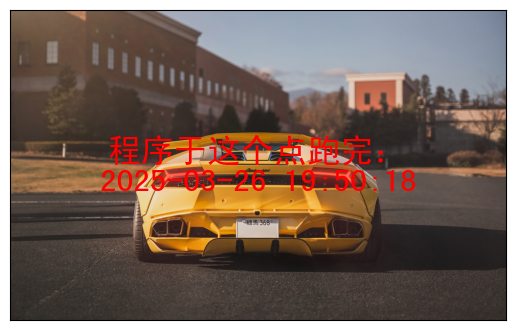

In [31]:
run_finish()

In [32]:
train_model_noCls(model, train_loader, val_loader, criterion, optimizer, epochs=1)

  0%|                                                                                          | 0/4375 [00:00<?, ?it/s]/tmp/ipykernel_70138/2338908956.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "labels": torch.tensor(label, dtype=torch.long),
100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [40:39<00:00,  1.79it/s]

Epoch 1/1, Loss: 2.0807973767961774


In [33]:
save_pickle_object(model, create_trained_models_path(f"ori_9319-{scheme_type}-rnd1.pkl"))

/mnt/d/forCoding_data/Tianchi_NLPNewsClassification/trained_models/ori_9319-20250326_1-rnd1.pkl


In [34]:
train_model_noCls(model, train_loader, val_loader, criterion, optimizer, epochs=1)
save_pickle_object(model, create_trained_models_path(f"ori_9319-{scheme_type}-rnd1.pkl"))

  0%|                                                                                          | 0/4375 [00:00<?, ?it/s]/tmp/ipykernel_70138/2338908956.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "labels": torch.tensor(label, dtype=torch.long),
100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [40:44<00:00,  1.79it/s]

Epoch 1/1, Loss: 2.070450069155012
/mnt/d/forCoding_data/Tianchi_NLPNewsClassification/trained_models/ori_9319-20250326_1-rnd1.pkl


In [35]:
from torch.utils.tensorboard import SummaryWriter
import shutil

# 训练和评估模型
def train_model_Cls(model, train_loader, val_loader, criterion, optimizer, epochs=2):

    ## loss_weights仅用于无监督预训练场景：
    loss_weights={'cls': 1.0, 'mlm': 0.5, 'sop': 0.5}
    
    model.to(device)
    
    log_path = "runs/Logs"
    if os.path.exists(
        os.path.dirname(log_path)
    ):
        shutil.rmtree(os.path.dirname(log_path))
        
    writer = SummaryWriter(log_dir=log_path)
    
    total_train_step = 0
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        loss_sum = 0
        for batch, input_tfidfs, targets in tqdm.tqdm(train_loader):
            input_tfidfs, targets = input_tfidfs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            # 分类任务
            cls_output, _ = model(
                input_ids=batch['input_ids'].to(device),
                attention_mask=batch['attention_mask'].to(device),
                mode = "supervised",
                x_tfidf = input_tfidfs,
            )
            cls_loss = nn.CrossEntropyLoss()(cls_output, batch['labels'].to(device))
            # # MLM任务
            # _, mlm_losses = model(
            #     input_ids=batch['mlm_input_ids'].to(device),
            #     attention_mask=batch['attention_mask'].to(device),
            #     mlm_labels=batch['mlm_labels'].to(device)
            # )
            # # SOP任务
            # _, sop_losses = model(
            #     input_ids=batch['sop_input_ids'].to(device),
            #     attention_mask=batch['sop_attention_mask'].to(device),
            #     sop_labels=batch['sop_labels'].to(device)
            # )
            # 加权总损失
            total_loss = (
                loss_weights['cls'] * cls_loss # +
                # loss_weights['mlm'] * mlm_losses['mlm'] +
                # loss_weights['sop'] * sop_losses['sop']
            )
            total_loss.backward()
            optimizer.step()
            
            train_loss += total_loss.item()
            
            _, predicted = torch.max(cls_output, 1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            total_train_step += 1
            loss_sum += total_loss.item()
            if total_train_step % 10 == 0:
                # print(total_train_step//10)
                writer.add_scalar(f"train_loss_detail-{scheme_type}", loss_sum/10, total_train_step//10)
                loss_sum = 0
                
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {train_loss/len(train_loader)}, Accuracy: {100.*correct/total}%') ## 
        writer.add_scalar(f"epoch_loss-{scheme_type}", train_loss/len(train_loader), epoch+1)
        
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            total_predicted = []
            total_label = []
            for batch, input_tfidfs, targets in tqdm.tqdm(val_loader):
                input_tfidfs, targets = input_tfidfs.to(device), targets.to(device)
                outputs, _ = model(
                    input_ids=batch['input_ids'].to(device),
                    attention_mask=batch['attention_mask'].to(device),
                    mode = "supervised",
                    x_tfidf = input_tfidfs
                )
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

                total_predicted += list(predicted.cpu())
                total_label += list(targets.cpu())
        f1 = f1_score(total_label, total_predicted, average='macro')

        print(f'Validation Loss: {val_loss/len(val_loader)}, Accuracy: {100.*correct/total}%, f1 score is {f1}')
    
    writer.close()

In [36]:
train_model_Cls(model, train_loader, val_loader, criterion, optimizer, epochs=1)

  0%|                                                                                          | 0/4375 [00:00<?, ?it/s]/tmp/ipykernel_70138/2338908956.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "labels": torch.tensor(label, dtype=torch.long),
100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [42:18<00:00,  1.72it/s]


Epoch 1/1, Loss: 0.38019879073415486, Accuracy: 88.57571428571428%


100%|███████████████████████████████████████████████████████████████████████████████| 1875/1875 [18:20<00:00,  1.70it/s]


Validation Loss: 0.2178853955090046, Accuracy: 93.26666666666667%, f1 score is 0.9165617297136406


In [37]:
train_model_Cls(model, train_loader, val_loader, criterion, optimizer, epochs=1)

  0%|                                                                                          | 0/4375 [00:00<?, ?it/s]/tmp/ipykernel_70138/2338908956.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "labels": torch.tensor(label, dtype=torch.long),
100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [42:35<00:00,  1.71it/s]


Epoch 1/1, Loss: 0.20697591470330953, Accuracy: 93.55214285714285%


100%|███████████████████████████████████████████████████████████████████████████████| 1875/1875 [18:12<00:00,  1.72it/s]


Validation Loss: 0.19919938412259022, Accuracy: 93.73666666666666%, f1 score is 0.9221848968470973


In [39]:
train_model_Cls(model, train_loader, val_loader, criterion, optimizer, epochs=1)

  0%|                                                                                          | 0/4375 [00:00<?, ?it/s]/tmp/ipykernel_70138/2338908956.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "labels": torch.tensor(label, dtype=torch.long),
100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [42:01<00:00,  1.73it/s]


Epoch 1/1, Loss: 0.16746635339409113, Accuracy: 94.77428571428571%


100%|███████████████████████████████████████████████████████████████████████████████| 1875/1875 [18:12<00:00,  1.72it/s]


Validation Loss: 0.19696597721502185, Accuracy: 93.85833333333333%, f1 score is 0.9265557951627227


In [40]:
train_model_Cls(model, train_loader, val_loader, criterion, optimizer, epochs=1)

  0%|                                                                                          | 0/4375 [00:00<?, ?it/s]/tmp/ipykernel_70138/2338908956.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "labels": torch.tensor(label, dtype=torch.long),
100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [42:15<00:00,  1.73it/s]


Epoch 1/1, Loss: 0.14310889443222966, Accuracy: 95.42714285714285%


100%|███████████████████████████████████████████████████████████████████████████████| 1875/1875 [18:22<00:00,  1.70it/s]


Validation Loss: 0.19064752218847472, Accuracy: 94.21833333333333%, f1 score is 0.9287231067053872


In [42]:
train_model_Cls(model, train_loader, val_loader, criterion, optimizer, epochs=1)

  0%|                                                                                          | 0/4375 [00:00<?, ?it/s]/tmp/ipykernel_70138/2338908956.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "labels": torch.tensor(label, dtype=torch.long),
100%|███████████████████████████████████████████████████████████████████████████████| 4375/4375 [42:18<00:00,  1.72it/s]


Epoch 1/1, Loss: 0.12424296306627138, Accuracy: 95.94142857142857%


100%|███████████████████████████████████████████████████████████████████████████████| 1875/1875 [18:26<00:00,  1.69it/s]


Validation Loss: 0.2048788850190118, Accuracy: 94.05%, f1 score is 0.9272171584754549


In [41]:
save_pickle_object(model, create_trained_models_path(f"ori_9319-{scheme_type}-rnd2.pkl"))

/mnt/d/forCoding_data/Tianchi_NLPNewsClassification/trained_models/ori_9319-20250326_1-rnd2.pkl


# 预测一下试试

In [46]:
# model = load_pickle_object(create_trained_models_path(f"ori_9319-{scheme_type}.pkl"))

In [48]:
model.eval()
with torch.no_grad():
    total_predicted = []
    for batch, input_tfidfs, targets in tqdm.tqdm(test_loader):
        input_tfidfs, targets = input_tfidfs.to(device), targets.to(device)
        outputs, _ = model(
            input_ids=batch['input_ids'].to(device),
            attention_mask=batch['attention_mask'].to(device),
            mode = "supervised",
            x_tfidf = input_tfidfs
        )
        _, predicted = torch.max(outputs, 1)
        total_predicted += list(predicted)

  0%|                                                                                            | 0/32 [00:00<?, ?it/s]/tmp/ipykernel_64921/2338908956.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "labels": torch.tensor(label, dtype=torch.long),
100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [00:15<00:00,  2.09it/s]


In [49]:
oot_rst = [int(x) for x in total_predicted]
len(oot_rst)

1000

In [50]:
store_data_to_newbasepath(pd.DataFrame({"label": oot_rst}), f"rst-{scheme_type}", fmt="csv")

df.to_csv("/mnt/d/forCoding_data/Tianchi_NLPNewsClassification/preprocessedData/rst-20250326_1.csv", index=False)
data saved.


'/mnt/d/forCoding_data/Tianchi_NLPNewsClassification/preprocessedData/rst-20250326_1.csv'